<a href="https://colab.research.google.com/github/PrashubhAtri/heterogeneousSNNs/blob/main/Baselines/SNNs/SurrogateGradients/SNNwithVoltageFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 7.7 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/fzenke/randman

Cloning into 'randman'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 104 (delta 16), reused 34 (delta 8), pack-reused 59 (from 1)
Receiving objects: 100% (104/104), 683.31 KiB | 10.85 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [3]:
import sys
sys.path.append('/content/randman')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import randman
from randman import Randman
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [100]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [101]:
# Constants for data generation
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 10
time_step = 1e-3
nb_steps  = 200
batch_size = 256
n_samples = 500
SEED = 42

In [102]:
def standardize(x,eps=1e-7):
    # x's (which is actually y in the following code) shape will be [samples, units]
    # Therefore, 0-axis shows that the author standardize across all samples for each units
    mi,_ = x.min(0)
    ma,_ = x.max(0)
    return (x-mi)/(ma-mi+eps)

In [103]:
def make_spiking_dataset(nb_classes=10, nb_units=100, nb_steps=100, step_frac=1.0, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True, classification=True, seed=None):
    """ Generates event-based generalized spiking randman classification/regression dataset.
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work.
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args:
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns:
        A tuple of data,labels. The data is structured as numpy array
        (sample x event x 2 ) where the last dimension contains
        the relative [0,1] (time,unit) coordinates and labels.
    """

    data = []
    labels = []
    targets = []

    if SEED is not None:
        np.random.seed(SEED)

    max_value = np.iinfo(int).max
    randman_seeds = np.random.randint(max_value, size=(nb_classes,nb_spikes) )

    for k in range(nb_classes):
        x = np.random.rand(nb_samples,dim_manifold)

        # The following code shows that if more than one spike, different spikes, even for the same unit, are generated by independent mappings
        submans = [ randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k,i]) for i in range(nb_spikes) ]
        units = []
        times = []
        for i,rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1,-1),nb_samples,axis=0))
            times.append(y.numpy())

        units = np.concatenate(units,axis=1)
        times = np.concatenate(times,axis=1)
        events = np.stack([times,units],axis=2)
        data.append(events)
        labels.append(k*np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0), dtype=int)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:,:,0] *= nb_steps*step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets

In [104]:
def events_to_spike_train(data):
    """convert the data generated from manifold to spike train form

    Args:
        data (array): shape is [samples, nb_events, 2]

    Returns:
        spike_train: shape is [nb_samples, nb_time_steps, units]
    """

    # astyle() will discard the decimal to give integer timestep
    spike_steps = data[:, :, 0].astype(int)
    spike_units = data[:, :, 1].astype(int)
    # These will be the indices to entrices in the spike train to be set to 1

    # Use the index on spike train matrix [samples, steps, units]
    spike_train = np.zeros((data.shape[0], nb_steps, nb_inputs))
    sample_indicies = np.expand_dims(np.arange(data.shape[0]), -1)
    spike_train[sample_indicies, spike_steps, spike_units] = 1

    return spike_train

In [105]:
def get_randman_dataset():
    """generate a TensorDataset encapsulated x and y, where x is spike trains

    Returns:
        TensorDataset: [nb_samples, time_steps, units] and [nb_samples]
    """
    data, label = make_spiking_dataset(nb_classes=nb_outputs, nb_units=nb_inputs, nb_steps=nb_steps, dim_manifold=3, seed=42, nb_samples=n_samples)
    spike_train = events_to_spike_train(data)

    spike_train = torch.Tensor(spike_train).to(device)
    label = torch.Tensor(label).to(device)

    # encapulate using Torch.Dataset
    dataset = TensorDataset(spike_train, label)

    return dataset

In [106]:
# Hyperparameters
NB_HIDDEN_UNITS = int(nb_outputs * 1.5)
BETA = 0.85 # This can also be obtained using exp(-delta_t / tau)

In [107]:
spike_trains = get_randman_dataset()

In [108]:
sample, label = spike_trains[0]  # Access the first sample
print(f"Sample shape: {sample.shape}")
print(f"Label: {label}")

Sample shape: torch.Size([200, 100])
Label: 1.0


In [109]:
len(spike_trains)

5000

In [110]:
# Split into ttv sets
train, test, validation = 0.8, 0.1, 0.1

all_labels = [spike_trains[i][1] for i in range(len(spike_trains))]

# First split: train (80%) and temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(spike_trains)),
    test_size=test,
    # stratify=all_labels,
    random_state=SEED,
    shuffle=False
)

# Second split: val (10%) and test (10%) from temp
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    # stratify=[all_labels[i] for i in temp_idx],
    random_state=SEED,
    shuffle=False
)

from torch.utils.data import Subset
train_dataset = Subset(spike_trains, train_idx)
val_dataset = Subset(spike_trains, val_idx)
test_dataset = Subset(spike_trains, test_idx)

#Batch_size = 32
batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_labels = [spike_trains[i][1] for i in train_dataset.indices]
test_labels = [spike_trains[i][1] for i in test_dataset.indices]
val_labels = [spike_trains[i][1] for i in val_dataset.indices]

In [111]:
len(train_idx), len(val_idx), len(test_idx)

(4500, 250, 250)

In [112]:
# Example: Iterate through the training DataLoader
for batch_data, batch_labels in train_loader:
    print(f"Batch data shape: {batch_data.shape}")
    print(f"Batch labels: {batch_labels}")
    break

Batch data shape: torch.Size([32, 200, 100])
Batch labels: tensor([4., 7., 3., 5., 7., 8., 2., 8., 8., 1., 3., 5., 2., 7., 8., 1., 7., 2.,
        8., 1., 8., 4., 4., 4., 5., 1., 8., 9., 3., 9., 4., 5.])


In [113]:
len(test_loader), len(train_loader), len(val_loader)

(8, 141, 8)

In [114]:
# Visualize class distribution
from collections import Counter
labels = [int(label) for label in train_labels]
print(Counter(labels))
labels = [int(label) for label in test_labels]
print(Counter(labels))
labels = [int(label) for label in val_labels]
print(Counter(labels))

Counter({1: 460, 8: 460, 5: 460, 2: 456, 3: 455, 6: 445, 7: 443, 0: 443, 4: 440, 9: 438})
Counter({9: 35, 4: 30, 6: 28, 2: 28, 0: 24, 3: 24, 1: 22, 7: 22, 8: 19, 5: 18})
Counter({7: 35, 0: 33, 4: 30, 6: 27, 9: 27, 5: 22, 8: 21, 3: 21, 1: 18, 2: 16})


In [115]:
class SNN(nn.Module):
    def __init__(self, num_inputs=nb_inputs, num_hidden=100, num_outputs=nb_outputs, beta=0.95):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=100))

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=100), reset_mechanism="none")

        # Xavier Uniform Initialization for Stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)

In [116]:
def losscustom(mem, labels):
  # batch, classes, time_steps
  # import pdb; pdb.set_trace()
  labels = labels.long()
  non_labels = 1-labels

  batch_idx = torch.arange(mem.shape[0])

  correct = mem[batch_idx, labels]
  non_correct = mem[batch_idx, non_labels]

  diff = non_correct - correct
  diff_activated = torch.where(diff > 0, diff, torch.zeros_like(diff))
  return (diff_activated).mean()


In [117]:
def multiclass_membrane_margin_loss(mem, labels):
    """
    mem: Tensor of shape [batch_size, num_classes, time_steps]
    labels: Tensor of shape [batch_size]
    """
    batch_size, num_classes, time_steps = mem.shape
    labels = labels.long()

    # Get the membrane potentials for the correct classes: [batch_size, time_steps]
    correct_class_potentials = mem[torch.arange(batch_size), labels, :]  # [batch_size, time_steps]

    # Expand for broadcasting: [batch_size, 1, time_steps]
    correct_class_potentials = correct_class_potentials.unsqueeze(1)

    # Subtract correct potentials from all class potentials
    diff = mem - correct_class_potentials  # [batch_size, num_classes, time_steps]

    # Mask out the correct class
    mask = torch.ones_like(diff, dtype=torch.bool)
    mask[torch.arange(batch_size), labels, :] = False

    # Apply the mask
    diff_masked = diff[mask].view(batch_size, num_classes - 1, time_steps)

    # Hinge activation: penalize only when wrong class > correct
    diff_activated = torch.where(diff_masked > 0, diff_masked, torch.zeros_like(diff_masked))

    # Average over all samples, wrong classes, and time steps
    return diff_activated.mean()


In [118]:
from tqdm import tqdm

In [119]:
mem_out_cache = None

In [120]:
# Initialize model, loss, and optimizer
model = SNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training Loop
num_epochs = 5
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in tqdm(train_loader, total = len(train_loader)):
        # import pdb; pdb.set_trace()
        optimizer.zero_grad()
        mem_out = model(inputs)  # Shape: (time_steps, batch_size, num_outputs)


        # mem_out = mem_out.permute(1,2, 0)
        # mem_out = torch.max(mem_out, dim = -1)[0]


        # labels = labels.long()
        # loss = criterion(mem_out, labels)

        mem_out = mem_out.permute(1, 2, 0)
        loss = multiclass_membrane_margin_loss(mem_out, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        mem_out_aux = torch.max(mem_out, dim = -1)[0]
        predicted = torch.argmax(mem_out_aux, dim=1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # import pdb; pdb.set_trace()
            mem_out = model(inputs)
            # mem_out = mem_out.permute(1,2, 0)
            # mem_out = torch.max(mem_out, dim = -1)[0]
            # labels = labels.long()
            # loss = criterion(mem_out, labels)

            mem_out = mem_out.permute(1, 2, 0)
            loss = multiclass_membrane_margin_loss(mem_out, labels)
            val_loss += loss.item()

            mem_out_aux = torch.max(mem_out, dim = -1)[0]

            predicted = torch.argmax(mem_out_aux, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Acc: {train_accuracy*100:.2f}% | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Testing Loop
model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        mem_out = model(inputs)
        mem_out = mem_out.permute(1,2, 0)
        # mem_out = torch.max(mem_out, dim = -1)[0]
        # labels = labels.long()
        # loss = criterion(mem_out, labels)
        loss = multiclass_membrane_margin_loss(mem_out, labels)
        test_loss += loss.item()

        mem_out_aux = torch.max(mem_out, dim = -1)[0]

        predicted = torch.argmax(mem_out_aux, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch [1/5]
Train Acc: 33.40% | Train Loss: 0.0070 | Val Loss: 0.0040 | Val Acc: 54.80%


100%|██████████| 141/141 [00:43<00:00,  3.26it/s]


Epoch [2/5]
Train Acc: 69.53% | Train Loss: 0.0042 | Val Loss: 0.0030 | Val Acc: 82.00%


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch [3/5]
Train Acc: 86.96% | Train Loss: 0.0026 | Val Loss: 0.0022 | Val Acc: 86.00%


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch [4/5]
Train Acc: 90.04% | Train Loss: 0.0019 | Val Loss: 0.0017 | Val Acc: 88.00%


100%|██████████| 141/141 [00:44<00:00,  3.18it/s]


Epoch [5/5]
Train Acc: 92.16% | Train Loss: 0.0015 | Val Loss: 0.0019 | Val Acc: 87.20%

Final Test Results:
Test Loss: 0.0015 | Test Accuracy: 90.80%


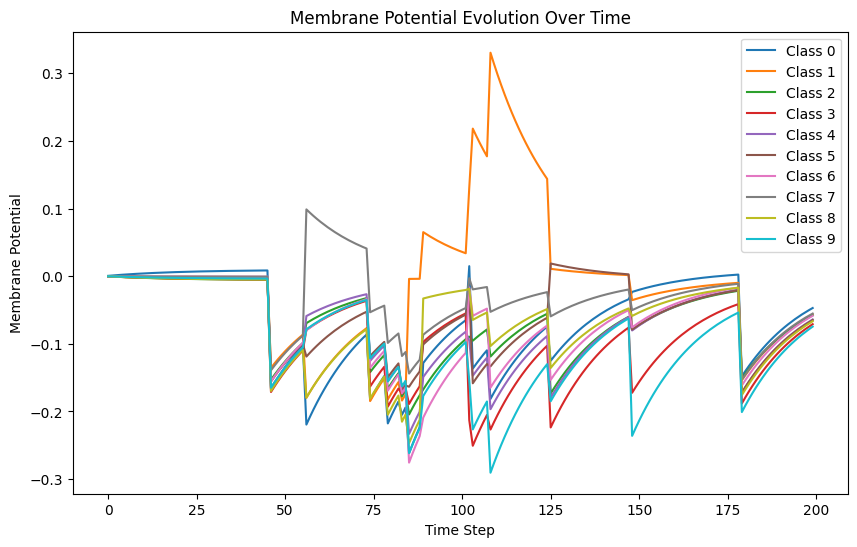

In [121]:
import matplotlib.pyplot as plt

# Select a batch for visualization
inputs, labels = next(iter(test_loader))
# inputs = torch.ones([1,100,100])
mem_out = model(inputs)  # (time_steps, batch_size, num_outputs)

# Select first sample in the batch
mem_potentials = mem_out[:, 0, :].cpu().detach().numpy()  # Shape: (time_steps, num_outputs)
time_steps = mem_potentials.shape[0]
num_classes = mem_potentials.shape[1]

# Plot membrane potential over time for each output class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.plot(range(time_steps), mem_potentials[:, class_idx], label=f"Class {class_idx}")

plt.xlabel("Time Step")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential Evolution Over Time")
plt.legend()
plt.show()

In [67]:
class SNNS(nn.Module):
    def __init__(self, num_inputs=nb_inputs, num_hidden=100, num_outputs=nb_outputs, beta=0.95):
        super(SNNS, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=100))

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=100))

        # Xavier Uniform Initialization for Stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)

In [73]:
model = SNN()
# Load best model for testing
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

# Testing Loop
model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        mem_out = model(inputs)
        mem_out = mem_out.permute(1,2, 0)
        # mem_out = torch.max(mem_out, dim = -1)[0]
        # labels = labels.long()
        # loss = criterion(mem_out, labels)
        loss = losscustom(mem_out, labels)
        test_loss += loss.item()

        mem_out_aux = torch.max(mem_out, dim = -1)[0]

        predicted = torch.argmax(mem_out_aux, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")



Final Test Results:
Test Loss: 0.0068 | Test Accuracy: 99.00%


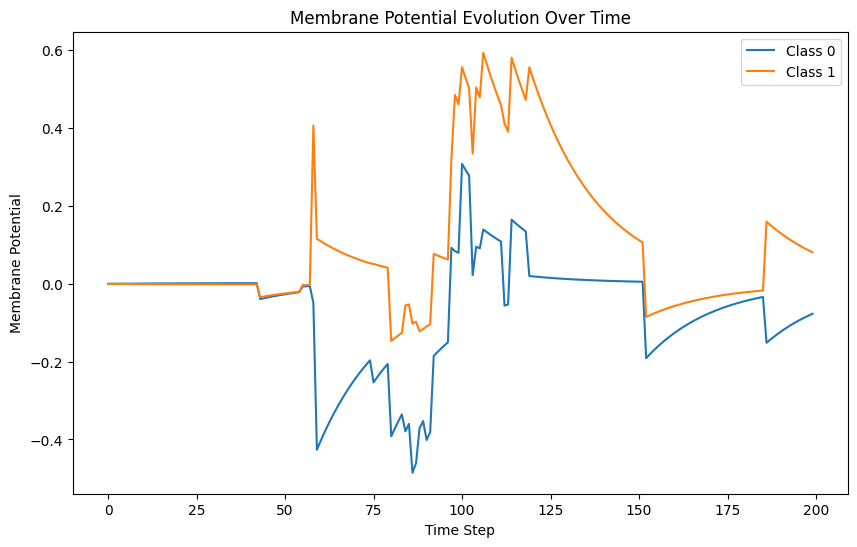

In [76]:
import matplotlib.pyplot as plt

# Select a batch for visualization
inputs, labels = next(iter(test_loader))
# inputs = torch.ones([1,100,100])
mem_out = model(inputs)  # (time_steps, batch_size, num_outputs)

# Select first sample in the batch
mem_potentials = mem_out[:, 0, :].cpu().detach().numpy()  # Shape: (time_steps, num_outputs)
time_steps = mem_potentials.shape[0]
num_classes = mem_potentials.shape[1]

# Plot membrane potential over time for each output class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.plot(range(time_steps), mem_potentials[:, class_idx], label=f"Class {class_idx}")

plt.xlabel("Time Step")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential Evolution Over Time")
plt.legend()
plt.show()

In [59]:
model

SNN(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (lif2): Leaky()
)

In [36]:
# for batch in train_loader:
#     break

In [37]:
# batch[0].shape, batch[1].shape

In [38]:
# model_temp = SNN()

In [39]:
# aux_out = model_temp(batch[0])

In [40]:
# aux_out.shape
# aux_out= aux_out.permute(1, 2, 0)
# aux_out.shape

In [41]:
# losscustom(aux_out, batch[1])

In [42]:
# aux_out[torch.arange(aux_out.shape[0]), labels].shape

In [43]:
# losscustom(aux_out, batch[1])

In [44]:
# aux_out

In [46]:
model

SNN(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (lif2): Leaky()
)